In [1]:
from typing import Annotated, Dict, TypedDict, Sequence
from langgraph.graph import StateGraph, START,END, add_messages
from langchain_ollama import ChatOllama

In [2]:
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage, SystemMessage
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_qdrant import QdrantVectorStore


In [3]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [5]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

vector_store = QdrantVectorStore.from_existing_collection(
            url="http://localhost:6333/",
            collection_name="html",
            embedding=embeddings,
        )

@tool
def html_context(user_query: str):
    """Use this tool to fetch relevant HTML to give it to AI model so that it will be changed according to user_query"""
    print("Query ", user_query)
    
    results = vector_store.similarity_search(
        user_query, k=2
    )
    print(results)
    if not results:
        return {"messages": "No Context found"}
    filtered_results = [doc for doc in results if doc.metadata.get("tag") not in ["comment", "link"]]
    
    context_text="".join("{\n ID:"+ d.metadata["_id"] + ",\ncontent: " + d.page_content + "\n}" for d in filtered_results)

    print(context_text)
    return {"messages": context_text}


@tool
def css_context(user_query: str):
    """Use this tool to get relevant CSS classes of the html element and pass it in case of style change in the html"""
    print("Inside CSS Context")
    results = vector_store.similarity_search(
        "style sheet", k=1
    )
    
    if not results:
        return "No relevant CSS context found."
    filtered_results = [doc for doc in results if doc.metadata.get("tag") in ["style"]]
    context_text="".join("{\n ID:"+ d.metadata["_id"] + ",\ncontent: " + d.page_content + "\n}" for d in filtered_results)
    print(context_text)
    return context_text
    

@tool
def js_context(user_query: str):
    """Use this tool to fetch relevant JavaScript to give it to AI model so that it will be changed according to user_query"""
    
    results = vector_store.similarity_search(
        user_query, k=2
    )
    if not results:
        return "No relevant JAVASCRIPT context found."
    filtered_results = [doc for doc in results if doc.metadata.get("tag") in ["script"]]
    context_text="".join("{\n ID:"+ d.metadata["_id"] + ",\ncontent: " + d.page_content + "\n}" for d in filtered_results)
    return context_text


tools = [html_context,css_context, js_context]


llm = ChatOllama(
    base_url="http://localhost:11434/",
    model="qwen2.5-coder:1.5b",
    temperature=0
).bind_tools(tools=tools)

def call_llm(state: AgentState) -> AgentState: 
    print("Calling LLM")
    system_message = SystemMessage(content="You are a coding assistant. Based on the user query, pick the right tools to get the context and answer. If it is a new section, don't call the tools. Just write the HTML of the new section with mock data. If there is a modification in the existing section, fetch html using tools and if there is any change in the styling of the section, fetch css using tool and if there is any change in the interactive part of the section, fetch javascript using tool. Return the modified HTML, CSS and JS with ID passed in the context(if any). And write a summary about 2-3 lines on what changes have been done.")
    response = llm.invoke(
        [system_message] + state["messages"]
    )
    return {"messages": response}

In [7]:
# conditional edge - function to decide where to go next
# Logic -  If the last message has tool_calls, then it should go to that tool. else END

def should_continue(state: AgentState):
    """This is a conditional edge. Decides it should loop or not"""
    last_message = state["messages"][-1]
    if not last_message.tool_calls:
        return "END"
    else:
        return "continue"
    


In [8]:
# Construct the graph
graph = StateGraph(AgentState)

graph.add_node("call_model",call_llm)

tool_node = ToolNode(tools=tools)
graph.add_node("tool_node", tool_node)

graph.add_edge(START, "call_model")
graph.add_conditional_edges(
    "call_model",
    should_continue,
    {
        "continue": "tool_node",
        "END": END
    }
)
graph.add_edge("tool_node", "call_model")

agent = graph.compile()

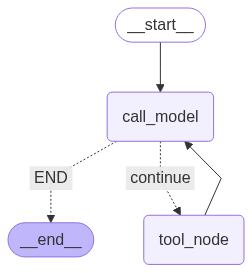

In [9]:
from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))

In [10]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()



In [11]:
inputs = {
    "messages": [HumanMessage(content="Change the color of navigation bar to white")]
}

print_stream(agent.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Change the color of navigation bar to white
Calling LLM
================================== Ai Message ==================================
Tool Calls:
  html_context (32a819d5-c144-432f-a56a-437f0eb2a2ca)
 Call ID: 32a819d5-c144-432f-a56a-437f0eb2a2ca
  Args:
    user_query: change the color of navigation bar to white
  css_context (86c213b2-ffd0-4395-934f-ad66ec663abd)
 Call ID: 86c213b2-ffd0-4395-934f-ad66ec663abd
  Args:
    user_query: change the color of navigation bar to white
  js_context (c1a4d3bb-5411-4a74-92ab-3eb64a148207)
 Call ID: c1a4d3bb-5411-4a74-92ab-3eb64a148207
  Args:
    user_query: change the color of navigation bar to white
Query  change the color of navigation bar to white
Inside CSS Context
[Document(metadata={'id': 9, 'parent': 'body', 'tag': 'comment', 'next': 'part_10', '_id': '17ba6b6a-97eb-490d-ab3a-fde6bf5381b1', '_collection_name': 'html'}, page_content='<!-- Navigation -->')